# Proyek Pertama [Predictive Analytics]: Pima Indians Diabetes Database
- **Nama:** Permata Ayu Rahmawati
- **Email:** permathaayu21@gmail.com

## Import Semua Packages/Library yang Digunakan

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from xgboost import XGBClassifier, plot_importance
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
import pickle
from google.colab import files

## Data Preparation

### Data Loading

In [2]:
# Upload kaggle.json
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
# Setup Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d uciml/pima-indians-diabetes-database
!unzip pima-indians-diabetes-database.zip

Dataset URL: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database
License(s): CC0-1.0
Archive:  pima-indians-diabetes-database.zip
  inflating: diabetes.csv            


In [5]:
# Load dataset
df = pd.read_csv('diabetes.csv')

## EDA(Exploratory Data Analyst)

### Data Info

In [6]:
def perform_eda(df):
    """Fungsi untuk melakukan EDA lengkap"""
    # 3.1. Data Overview
    print("\n=== Data Overview ===")
    print(df.info())
    print("\nDescriptive Statistics:")
    print(df.describe())

In [8]:
# Check missing values (nilai 0)
medical_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
print("\n=== Persentase Nilai 0 ===")
for col in medical_features:
  zero_percent = (df[col] == 0).mean() * 100
print(f"{col}: {zero_percent:.1f}%")



=== Persentase Nilai 0 ===
BMI: 1.4%


### Data Visualisasi

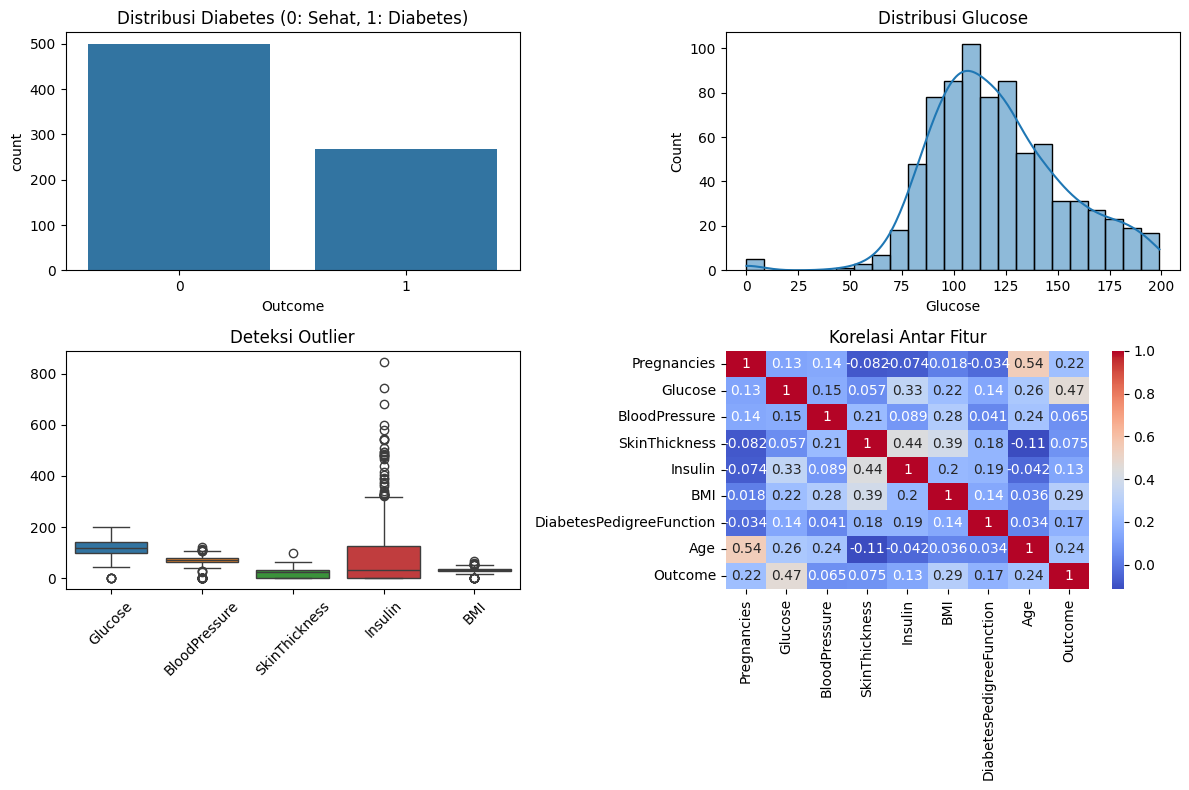


=== Data Overview ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

Descriptive Statistics:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531     

In [10]:
plt.figure(figsize=(12,8))

# Distribusi Target
plt.subplot(2,2,1)
sns.countplot(x='Outcome', data=df)
plt.title('Distribusi Diabetes (0: Sehat, 1: Diabetes)')

# Distribusi Fitur
plt.subplot(2,2,2)
sns.histplot(df['Glucose'], kde=True)
plt.title('Distribusi Glucose')

# Boxplot
plt.subplot(2,2,3)
sns.boxplot(data=df[medical_features])
plt.title('Deteksi Outlier')
plt.xticks(rotation=45)

# Correlation Matrix
plt.subplot(2,2,4)
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Korelasi Antar Fitur')

plt.tight_layout()
plt.savefig('eda_results.png')
plt.show()

perform_eda(df)

### Korelasi Matriks

## Preprocessing

In [11]:
# Handle missing values (0)
medical_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in medical_features:
    df[col] = df[col].replace(0, df[col].median())

In [12]:
# Split data
X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [13]:
# Handle Class Imbalance
print("\nClass Distribution Before SMOTE:", y_train.value_counts())
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("Class Distribution After SMOTE:", pd.Series(y_train_res).value_counts())


Class Distribution Before SMOTE: Outcome
0    400
1    214
Name: count, dtype: int64
Class Distribution After SMOTE: Outcome
0    400
1    400
Name: count, dtype: int64


## Model

In [14]:
# 5. BASE MODEL XGBOOST
base_model = XGBClassifier(random_state=42, eval_metric='logloss')
base_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [15]:
# Evaluasi
print("=== Baseline XGBoost ===")
print(classification_report(y_test, base_model.predict(X_test)))
print("ROC-AUC:", roc_auc_score(y_test, base_model.predict_proba(X_test)[:, 1]))

=== Baseline XGBoost ===
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       100
           1       0.70      0.61      0.65        54

    accuracy                           0.77       154
   macro avg       0.75      0.74      0.74       154
weighted avg       0.77      0.77      0.77       154

ROC-AUC: 0.8144444444444444


## Hyperparameter Tuning

In [26]:
# TUNED MODEL XGBOOST
# Pipeline
pipeline = imbpipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(random_state=42, eval_metric='logloss'))
])

# Improved Parameter Grid
param_grid = {
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.001, 0.01, 0.1],
    'xgb__n_estimators': [100, 200, 300],
    'xgb__gamma': [0, 0.1, 0.2],
    'xgb__subsample': [0.8, 1.0]
}

# Initialize StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Grid Search
grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring='roc_auc',
    cv=cv,  # Menggunakan StratifiedKFold yang sudah diinisialisasi
    n_jobs=-1,
    verbose=2
)
grid.fit(X_train_res, y_train_res)

# Best model
best_model = grid.best_estimator_
print("\nBest Parameters:", grid.best_params_)
print("Best CV AUC:", grid.best_score_)


Fitting 10 folds for each of 162 candidates, totalling 1620 fits

Best Parameters: {'xgb__gamma': 0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__n_estimators': 200, 'xgb__subsample': 0.8}
Best CV AUC: 0.89


## Evaluasi

In [28]:
# Evaluate
print("\n=== Tuned XGBoost ===")
print(classification_report(y_test, best_model.predict(X_test)))
print("ROC-AUC:", roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]))


=== Tuned XGBoost ===
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       100
           1       0.64      0.69      0.66        54

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.76       154

ROC-AUC: 0.8237037037037037


### visualisasi akhir

<Figure size 1000x600 with 0 Axes>

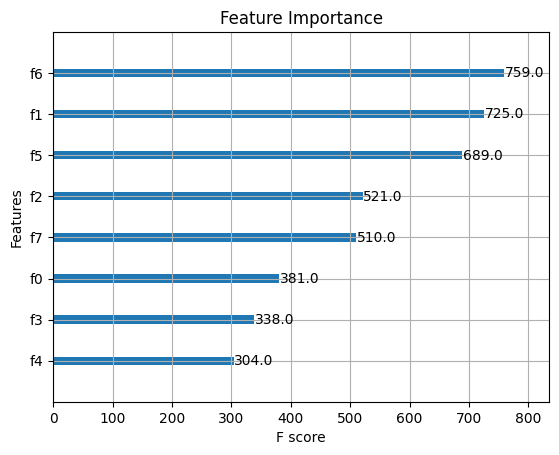

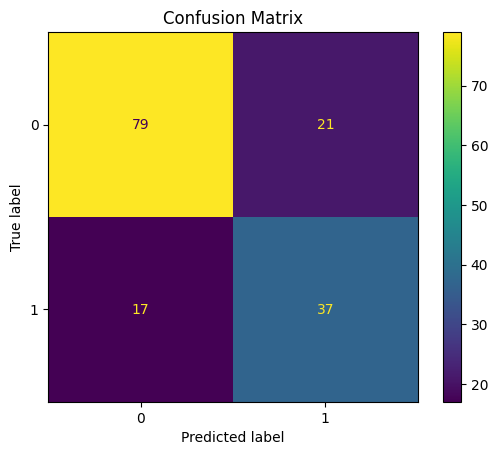

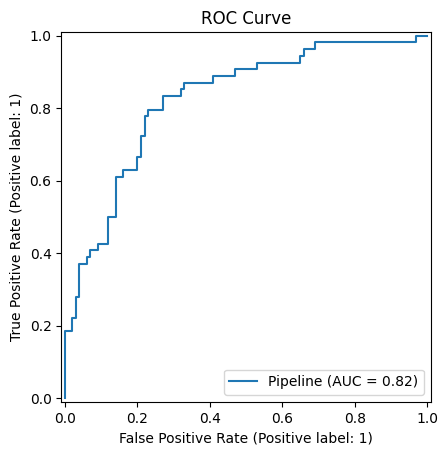

In [29]:
# VISUALIZATION
# Feature Importance
plt.figure(figsize=(10,6))
plot_importance(best_model.named_steps['xgb'])
plt.title('Feature Importance')
plt.show()

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title('ROC Curve')
plt.show()

## Penyimpanan Model

In [ ]:
## 7. Model Saving
# Save the best model
with open('diabetes_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print("\nModel saved as diabetes_model.pkl")


## Prediksi

In [30]:
# 7. SAMPLE PREDICTION
sample = [[6, 148, 72, 35, 0, 33.6, 0.627, 50]]  # Contoh data pasien
pred = best_model.predict(sample)
proba = best_model.predict_proba(sample)[0][1]

print(f"\nPrediction: {'Diabetes' if pred[0] == 1 else 'Healthy'}")
print(f"Probability: {proba*100:.2f}%")


Prediction: Diabetes
Probability: 97.05%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
